In [1]:
# !pip install -U torch catalyst tensorboard

# Generative Models

Hi! Today we are going to learn about generative models. We'll continue to work with handwritten numbers, but we will generate with different models.

In [2]:
from catalyst.utils import set_global_seed, get_device

In [3]:
set_global_seed(42)
# device = get_device()
device = "cuda:1"

We'll work with `MNIST` dataset. Download it, show examples of the writting and prepare the dataset to be loaded into models.

In [4]:
from catalyst.contrib.datasets import mnist


train = mnist.MNIST(".", train=True, download=True)
valid = mnist.MNIST(".", train=False, download=True)

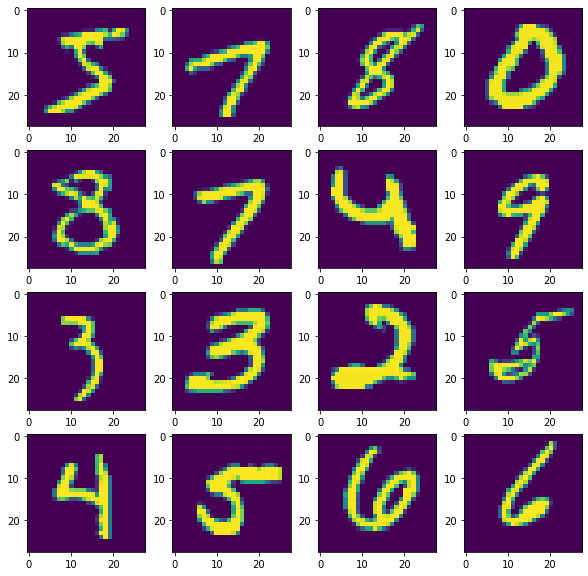

In [5]:
import matplotlib.pyplot as plt


_, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(16):
    axs[i // 4][i % 4].imshow(train[100 * i + i][0])

In [6]:
import torch
import torch.nn as nn

In [7]:
from catalyst.utils import get_loader


batch_size = 1024
num_workers = 4

def transform(x):
    image = torch.FloatTensor(x["image"])
    image = torch.where(image > 127, torch.ones(image.shape), torch.zeros(image.shape))
    return {'image': image, "targets": x["targets"]}


train_data_loader = get_loader(
    train,
    open_fn=lambda x : {'image': x[0].reshape(1, 28, 28), 'targets': x[1]},
    dict_transform=transform,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    sampler=None,
    drop_last=True,
)

valid_data_loader = get_loader(
    valid,
    open_fn=lambda x : {'image': x[0].reshape(1, 28, 28), 'targets': x[1]},
    dict_transform=transform,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    sampler=None,
    drop_last=False,
)

## GAN

For GAN model, we need a Discriminator and a Generator. The Discriminator will judge generated images, how do they like real one. The Generator tries to fool the Discriminator.

Notice that Generator is similar to Decoder in AE/VAE perspective. It will required later.

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = ... # from image to feature vector
        self.clf = ... # classify vectors
        
    def forward(self, images):
        features = self.feature_extractor(images)
        return self.clf(features)

In [9]:
from catalyst.contrib.nn.modules import Lambda


class Generator(nn.Module):
    def __init__(self, image_size=(28, 28), latent_size=10):
        super().__init__()
        
        self.image_size = image_size
        self.latent_size = latent_size
        
        self.map_generator = nn.Sequential(
            nn.Linear(latent_size, 64 * 49),
            Lambda(lambda x: x.view(x.size(0), 64, 7, 7)),
        )
        self.deconv = nn.Sequential(
            self.make_up_layer_(64, 16), # 7 -> 14
            self.make_up_layer_(16, 4), # 14 -> 28
        )
            
        self.output = nn.Sequential(
            nn.Conv2d(4, 1, 3, padding=1),
            nn.Sigmoid()
        )
            
    def forward(self, points):
        feature_map = self.map_generator(points)
        feature_map = self.deconv(feature_map)
        return self.output(feature_map)
            
    def make_up_layer_(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(
                    in_channels,
                    out_channels,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                    out_channels,
                    out_channels,
                    kernel_size=3,
                    padding=1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

To monitor decoded images, we have to write a new callback function. It will log image into the tensorboard.

In [10]:
from catalyst.core import Callback, CallbackOrder


class LogFigureCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.External)

    def on_epoch_end(self, runner):
        tb_callback = runner.callbacks["_tensorboard"]
        logger = tb_callback.loggers[runner.loader_name]
        logger.add_images(
            "image/epoch", 
            runner.output["generated_images"][:64], 
            global_step=runner.epoch
        )

Create model, criterion, optimizer. Train model!

In [11]:
from catalyst.contrib.nn.optimizers import RAdam


generator_1 = Generator()
discriminator = Discriminator()

model = {"generator": ..., "discriminator": ...} # set models
optimizer = {
    "generator": ...
    "discriminator": ...
} # set optimizers
criterion = nn.BCEWithLogitsLoss()
loaders = {
    "train": ..., # set loaders
}

In [12]:
from catalyst import dl


callbacks = [
    dl.OptimizerCallback(
        optimizer_key="generator", 
        metric_key="loss_generator"
    ),
    dl.OptimizerCallback(
        optimizer_key="discriminator", 
        metric_key="loss_discriminator"
    ),
    LogFigureCallback()
]

Training process consists in two phases: discriminator and generator parts. The discriminator is differential metrics of "fakeness". So, it's trained to discriminate objects by `BinaryCrossEntropyLoss`. Because the discriminator is differential, we can pass knowledge about real images by backpropagation.

In [13]:
class GANRunner(dl.Runner):

    def _handle_batch(self, batch):
        real_images = batch["image"]
        batch_metrics = {}
        latent_size = self.model["generator"].latent_size
        
        # Sample random points in the latent space
        batch_size = real_images.shape[0]
        random_latent_vectors = torch.randn(batch_size, latent_size).to(self.device)
        
        # Generate fake images by random points
        generated_images = ... # don't forget about .detach()
        # Combine them with real images
        combined_images = torch.cat([generated_images, real_images])
        
        # Assemble labels discriminating real from fake images
        labels = torch.cat([
            torch.ones((batch_size, 1)), torch.zeros((batch_size, 1))
        ]).to(self.device)
        
        # Train the discriminator
        predictions = ... # get predicitons from discriminator
        batch_metrics["loss_discriminator"] = ... # calculate loss
        
        # Sample random points in the latent space
        random_latent_vectors = torch.randn(batch_size, latent_size).to(self.device)
        # Assemble labels that say "all real images"
        misleading_labels = torch.zeros((batch_size, 1)).to(self.device)
        
        # Train the generator
        generated_images = ... # generate fake images
        self.output = {"generated_images": generated_images}
        predictions = self.model["discriminator"](generated_images)
        batch_metrics["loss_generator"] = ... # calculate loss for generator
        
        self.batch_metrics.update(**batch_metrics)


runner = GANRunner(device=device)

In [14]:
from datetime import datetime
from pathlib import Path


logdir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")

# %reload_ext tensorboard
# %tensorboard --logdir logs

In [15]:
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    callbacks=callbacks,
    num_epochs=10,
    verbose=True,
    logdir=logdir,
    main_metric="loss_generator",
    minimize_metric=True,
)

## VAE-GAN

Remember that the Discriminator is a Decoder? Let's add an Encoder in our training rutin:

![](https://habrastorage.org/web/7a1/8db/d39/7a18dbd3969048c2b085cc707e539f0c.png)

It will make latent space meaningfull.

To train all these models, we need new loss function for encoder model. We need to compare results from the Discriminator with the real images. Instead from comparing images in the original sizes, we can compare feature maps from the Discriminator.


https://arxiv.org/pdf/1512.09300.pdf

In [16]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten()
        )
        self.latent_space = nn.Linear(64, 2 * latent_size)
        
        self.latent_size = latent_size
        
    def forward(self, images):
        features = self.feature_extractor(images)
        latent = self.latent_space(features)
        return latent[:, :self.latent_size], latent[:, self.latent_size:]

In [17]:
class Discriminator_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = ... # from image to feature vector
        self.clf = ... # classify vectors
        
    def forward(self, images):
        features = self.feature_extractor(images)
        return self.clf(features), features

In [18]:
class KLVAELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, loc, log_scale):
        return (-0.5 * torch.sum(log_scale - loc.pow(2) - log_scale.exp(), dim=1)).mean()

In [19]:
encoder = Encoder()
generator_2 = Generator()
discriminator = Discriminator_v2().to(device)

model = {"generator": ..., "discriminator": ..., "encoder": ...}# set models
optimizer = {
    "generator": ...,
    "discriminator": ...,
    "encoder": ...,
} # set optimizers
criterion = {
    "bce": nn.BCEWithLogitsLoss(),
    "mse": nn.MSELoss(),
    "vae": KLVAELoss()
}
loaders = {
    "train": ..., # set loaders
}

In [20]:
callbacks = [
    LogFigureCallback(),
]

Look the architecture and parameter update rutine:

Model Architecture:
![image](https://habrastorage.org/web/701/bbb/212/701bbb21273045fc9ed4aab7e0529764.png)

Parameter Updates:
![image](https://habrastorage.org/getpro/habr/post_images/07a/d0b/dc0/07ad0bdc0524f17cd4ae6c6e1be3c36d.svg)

What we need to code?

- Encoding training: compact latent space (KL Loss) and object reconstruction
- Discriminator training: discriminate real from fake and reconstructed
- Generator/decoder training: object reconstruction and fake object generator

In [21]:
LOG_SCALE_MAX = 2
LOG_SCALE_MIN = -10


def normal_sample(loc, log_scale):
    scale = torch.exp(0.5 * log_scale)
    return loc + scale * torch.randn_like(scale)


class VAEGANRunner(dl.Runner):
    def _zero_grad(self):
        for optimizer in self.optimizer.values():
            optimizer.zero_grad()

    def _handle_batch(self, batch):
        real_images = batch["image"]
        batch_metrics = {}
        latent_size = self.model["generator"].latent_size
        
        # encoder-decoder part
        latent_loc, latent_log_scale = self.model["encoder"](real_images)
        loss_prior = self.criterion["vae"](latent_loc, latent_log_scale)
            
        latent_log_scale = torch.clamp(latent_log_scale, LOG_SCALE_MIN, LOG_SCALE_MAX)
        latent_vectors = normal_sample(latent_loc, latent_log_scale)
        
        decoded_images = self.model["generator"](latent_vectors)
        
        _, predictions_decoded = self.model["discriminator"](decoded_images)
        _, predictions_real = self.model["discriminator"](real_images)
        loss_dislike = ... # calculate dislike
        
        # generator part
        
        batch_size = real_images.shape[0]
        random_latent_vectors = torch.randn(batch_size, latent_size).to(self.device)
        
        generated_images = ... # generate images
        
        combined_images = torch.cat([generated_images, decoded_images])
        labels = torch.zeros((2 * batch_size, 1)).to(self.device)
        
        self.output = {"generated_images": generated_images}
        predictions, _ = self.model["discriminator"](combined_images)
        loss_generator = ... # calculate loss for generator
        
        # discriminator part
        
        latent_vectors = normal_sample(latent_loc, latent_log_scale)
        random_latent_vectors = torch.randn(batch_size, latent_size).to(self.device)
        
        decoded_images = ... # decode images
        generated_images = ... # generate images
        
        combined_images = torch.cat([generated_images, decoded_images, real_images]).detach()
        labels = torch.cat([
            torch.ones((2 * batch_size, 1)), torch.zeros((batch_size, 1))
        ]).to(self.device)
        predictions, _ = self.model["discriminator"](combined_images)
        loss_discriminator = ... # caalculate loos for discriminator
        
        # closely look at the picture above and sum up losses for all part of VAE-GAN
        batch_metrics["loss_encoder"] = ...
        batch_metrics["loss_generator"] = ...
        batch_metrics["loss_discriminator"] = ...
        if self.is_train_loader:
            batch_metrics["loss_encoder"].backward(retain_graph=True)
            optimizer["encoder"].step()
            self._zero_grad()
            
            batch_metrics["loss_generator"].backward(retain_graph=True)
            optimizer["generator"].step()
            self._zero_grad()
            
            batch_metrics["loss_discriminator"].backward()
            optimizer["discriminator"].step()
            self._zero_grad()
        
        self.batch_metrics.update(**batch_metrics)


runner = VAEGANRunner(device=device)

In [22]:
logdir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")

In [23]:
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    callbacks=callbacks,
    num_epochs=10,
    verbose=True,
    logdir=logdir,
    main_metric="loss_generator",
    minimize_metric=True,
)

How to compare models? Usually reseacher just closely look at the pictures. But they can use computer brains and eyes to compare generative models. Let's look at the one of them.

## Inception score

Wait, wat? We can create numerical metric for generative models? Yes, we can. The metric called Inception score. To calculate it, we need the image classificator and generated images. Let's do it.

\*Inception score usually calculates for generators, trained on ImageNet/CIFAR. But we have no time to train GAN on these datasets. So, we will work with MNIST.

In [24]:
clf_model = nn.Sequential(...).to(device) # create simple classification model
criterion = nn.CrossEntropyLoss()
optimizer = RAdam(clf_model.parameters(), lr=1e-2)

runner = dl.SupervisedRunner(
    device=device,
    input_key="image",
    output_key="logits",
    input_target_key="targets", 
)
runner.train(
    model=clf_model, 
    optimizer=optimizer,
    criterion=criterion,
    callbacks=[
        dl.AccuracyCallback()
    ],
    loaders={
        "train": train_data_loader,
        "valid": valid_data_loader
    },
    num_epochs=5,
    verbose=True,
)

Inception Score fomulating by this:

![](https://www.oreilly.com/library/view/generative-adversarial-networks/9781789136678/assets/0d33c46a-0a5f-4027-919c-30b910e6d93b.png)

where $p(y)$ – is probability of class in a dataset, $p(y|x)$ – is probability of class of object.

In [25]:
from tqdm.notebook import trange


def inception_score(model):
    p_y = torch.ones(10).to(device) / 10
    log_is = 0
    num_images = 50000
    batch_size = 100

    model.eval()
    with torch.no_grad():
        for _ in trange(num_images // batch_size):
            latent_size = model.latent_size
            random_latent_points = torch.randn((batch_size, latent_size)).to(device)
            generated = ... # generate images
            logits = ... # classify images 
            p_y_x = ... # get probabilities
            log_is += (torch.log(p_y_x) * p_y_x - torch.log(p_y) * p_y_x).sum(1)

    log_is /= num_images
    return torch.exp(log_is.mean())

In [26]:
inception_score(generator_1)

In [27]:
inception_score(generator_2)

## (Additional) Another point in VAE - GAN: AAE

AAE stands for Adversarial Autoencoders. It is like a inverted VAE-GAN. A main model become AE, but we will use Discriminator to compare points in a latent space. Let's code it.

In [37]:
class Disciriminator_v3(nn.Module):
    def __init__(self, latent_size=4):
        super().__init__()
        
        self.latent_size = latent_size
        
        self.model = nn.Sequential(
            nn.Linear(latent_size, 100),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        return self.model(z)

In [38]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten()
        )
        self.latent_space = nn.Linear(64, latent_size)
        
        self.latent_size = latent_size
        
    def forward(self, images):
        features = self.feature_extractor(images)
        latent = self.latent_space(features)
        # Instead of VAE, AAE use simple encoder
        # because it can be trained by samples, not distributions.
        return latent

In [39]:
class Decoder(nn.Module):
    def __init__(self, image_size=(28, 28), latent_size=10):
        super().__init__()
        
        self.image_size = image_size
        self.latent_size = latent_size
        
        self.map_generator = nn.Sequential(
            nn.Linear(latent_size, 64 * 49),
            Lambda(lambda x: x.view(x.size(0), 64, 7, 7)),
        )
        self.deconv = nn.Sequential(
            self.make_up_layer_(64, 16), # 7 -> 14
            self.make_up_layer_(16, 4), # 14 -> 28
        )
            
        self.output = nn.Sequential(
            nn.Conv2d(4, 1, 3, padding=1),
            nn.Sigmoid()
        )
            
    def forward(self, points):
        feature_map = self.map_generator(points)
        feature_map = self.deconv(feature_map)
        return self.output(feature_map)
            
    def make_up_layer_(self, in_channels, out_channels):
        return nn.Sequential(nn.ConvTranspose2d(
                    in_channels,
                    out_channels,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            )

In [40]:
class AE(nn.Module):
    def __init__(self, image_size=(28, 28), latent_size=4):
        super().__init__()

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(image_size, latent_size)
        
    def forward(self, images):
        latent = self.encoder(images)
        x_ = self.decoder(latent)

        return {
            "decoder_result": x_,
            "latent": latent
        }

In [41]:
autoencoder = AE()
discriminator = Disciriminator_v3()
model = {"autoencoder": autoencoder, "discriminator": discriminator}
optimizer = {
    "autoencoder": RAdam(autoencoder.parameters(), lr=1e-3), 
    "discriminator": RAdam(discriminator.parameters(), lr=1e-3),
}
criterion = nn.BCELoss()

In [42]:
callbacks = [
    LogFigureCallback(),
]

In [43]:
class AAERunner(dl.Runner):
    def _zero_grad(self):
        for optimizer in self.optimizer.values():
            optimizer.zero_grad()

    def _handle_batch(self, batch):
        real_images = batch["image"]
        batch_metrics = {}
        latent_size = self.model["discriminator"].latent_size
        batch_size = real_images.size(0)
        
        output = self.model["autoencoder"](real_images)
        fake_latent = output["latent"]
        decoded_images = output["decoder_result"]
        
        self.output = {"generated_images": decoded_images}
        normal_latent = torch.randn(fake_latent.size()).to(self.device)
        
        loss_ae = self.criterion(
            decoded_images.reshape(batch_size, -1), 
            real_images.reshape(batch_size, -1)
        )
        
        concat_latent = torch.cat([normal_latent, fake_latent]).detach()
        target = torch.cat(
            [torch.ones(batch_size), torch.zeros(batch_size)]
        ).to(self.device)
        pred = self.model["discriminator"](concat_latent)
        batch_metrics["loss_discriminator"] = self.criterion(
            pred, target
        )
        
        fake_pred = self.model["discriminator"](fake_latent)
        fake_target = torch.ones(batch_size).to(self.device)
        loss_fake_latent = self.criterion(
            fake_pred, fake_target
        )
        
        batch_metrics["loss_autoencoder"] = loss_ae + loss_fake_latent
        
        if self.is_train_loader:
            optimizer["discriminator"].zero_grad()
            batch_metrics["loss_discriminator"].backward(retain_graph=True)
            optimizer["discriminator"].step()
            
            optimizer["autoencoder"].zero_grad()
            batch_metrics["loss_autoencoder"].backward()
            optimizer["autoencoder"].step()
        
        self.batch_metrics.update(**batch_metrics)


runner = AAERunner(device=device)

In [44]:
logdir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")

In [45]:
runner.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    loaders=loaders,
    callbacks=callbacks,
    num_epochs=1000,
    verbose=True,
    logdir=logdir,
    main_metric="loss_autoencoder",
    minimize_metric=True,
)

1/1000 * Epoch (train): 100% 58/58 [00:06<00:00,  8.64it/s, loss_autoencoder=1.386, loss_discriminator=0.701]
[2020-10-29 06:01:36,696] 
1/1000 * Epoch 1 (train): loss_autoencoder=1.4332 | loss_discriminator=0.6939
2/1000 * Epoch (train): 100% 58/58 [00:06<00:00,  8.60it/s, loss_autoencoder=1.312, loss_discriminator=0.699]
[2020-10-29 06:01:43,509] 
2/1000 * Epoch 2 (train): loss_autoencoder=1.3466 | loss_discriminator=0.7018
3/1000 * Epoch (train): 100% 58/58 [00:06<00:00,  8.83it/s, loss_autoencoder=1.243, loss_discriminator=0.698]
[2020-10-29 06:01:50,224] 
3/1000 * Epoch 3 (train): loss_autoencoder=1.2759 | loss_discriminator=0.6979
4/1000 * Epoch (train): 100% 58/58 [00:06<00:00,  8.63it/s, loss_autoencoder=1.173, loss_discriminator=0.697]
[2020-10-29 06:01:57,117] 
4/1000 * Epoch 4 (train): loss_autoencoder=1.2055 | loss_discriminator=0.6957
5/1000 * Epoch (train): 100% 58/58 [00:06<00:00,  8.63it/s, loss_autoencoder=1.112, loss_discriminator=0.695]
[2020-10-29 06:02:03,962] 
5/1